In [126]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd

In [127]:
# Fetching S&P 500 data
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

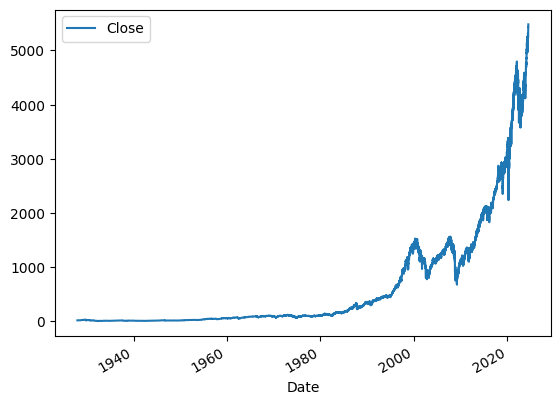

In [128]:
# Plotting the closing price
sp500.plot.line(y="Close", use_index=True)

In [129]:
# Removing unnecessary columns
del sp500["Dividends"]
del sp500["Stock Splits"]


In [130]:
# Creating the 'Tomorrow' and 'Target' columns
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [131]:
# Filtering and cleaning data from 1990 onwards
sp500 = sp500.loc["1990-01-01":].copy()

In [132]:
# Defining the model and predictors
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [133]:
# Making predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5454545454545454

<Axes: xlabel='Date'>

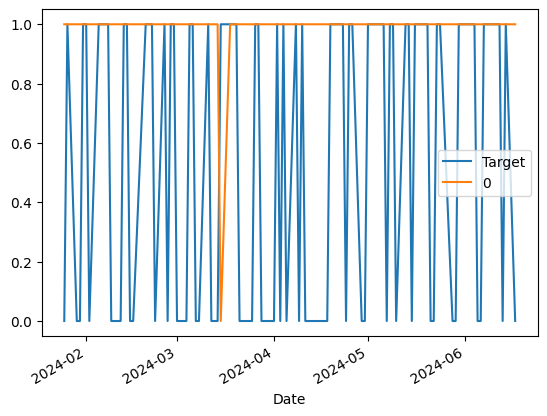

In [134]:
# Plotting the predictions
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [135]:
horizons = [2, 5, 60, 250, 1000]
predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    predictors += [ratio_column, trend_column]

In [136]:
# Clean data
sp500 = sp500.dropna()

In [137]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [138]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [139]:
# Backtesting the model
predictions = backtest(sp500, model, predictors)
print("Predictions Value Counts:", predictions["Predictions"].value_counts())
print("Precision Score:", precision_score(predictions["Target"], predictions["Predictions"]))
print("Target Value Counts:", predictions["Target"].value_counts() / predictions.shape[0])

Predictions Value Counts: Predictions
0.0    4346
1.0     834
Name: count, dtype: int64
Precision Score: 0.5743405275779376
Target Value Counts: Target
1    0.544788
0    0.455212
Name: count, dtype: float64
